# ES RBC tuning simulation
This script is used to numerically evaluate the SBO and CSBO tuning performance on the parameters of the ES RBC. To run this script, first you will need to run **simulation/NLopt_mp.py** and **simulation/grid_mp.py**. The results of the last script are used to calculate the kernel hyperparameters.

## Import dependencies

In [13]:
from __future__ import print_function, division, absolute_import
import os
import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import sys
sys.path.insert(0,'..')
from mtfunc.helper import *
import safeopt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import tqdm
import tensorflow as tf
from tensorflow import keras
mpl.rcParams['figure.figsize'] = (12, 4)
mpl.rcParams['axes.grid'] = True
#Define constants
hour=60
day=24*hour
#Battery capacity
C=96 #kWh
#Deviation of the battery capacity (for simulations with modified capacity, e.g. 500kWh capacity --> Cdev=5)
Cdev=1
#Hard constraints on the SoC, 30-80%
soc_lim=np.array([30,80])
#Maximum charge/discharge power
p_bat_lim=1*C #1C 
#Normalizing constants
p_std=p_bat_lim
soc_std=soc_lim[1]-soc_lim[0]# do not change unless necesary
#Set SoC reference
soc_ref=(soc_lim[1]+soc_lim[0])/2
#Define soft constraints (for constraint metric)
soc_softc=[32,80]
S_f_sp=55
#Set samplin time
dt=1
# Import battery model
# bat_dense_model=tf.keras.models.load_model('p-dsoc_2-7-1_.h5')
phib=np.asarray(pd.read_csv('../battery/PWLmodel_par_opti.csv',index_col='Unnamed: 0'))
#Get load power data
data=get_data('model_data/model_winter_data_2022_03_15_0131.csv',npy=False)

Define utility function with electricty tariff

In [14]:
P1=188 # buy price in euro/MWh
P2=170
P3=115
S1=53 #sell price in euro/MWh
B1=0
def price_fun(k=None):
    price=DemandSignal(day,dt,1)
    price.step_signal([0.29,0.33,0.54,0.71,0.87],[P3,P2,P1,P2,P1,P3])
    if k is None:
        return price.signal
    else:
        return price.signal[k]

## Set simulation framework

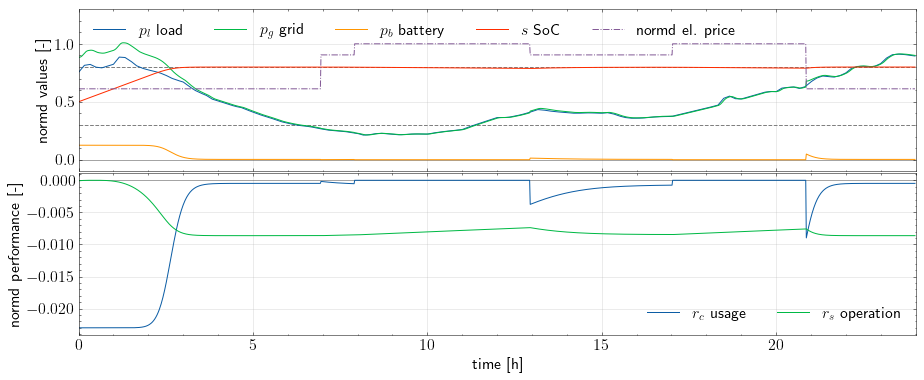

((-16.61653052600083, -4.440889124727503),
 79.95222548350694,
 78.68682487604678)

In [31]:
#Define battery model generator
def batt_model_generator(x,soc_i,mtype='PWL',model=None):
    # Creates generator of the battery model
    # x: battery model parameters
    # soc_i: initial SoC
    # mtype: set to 'PWL' for EPWL and 'ANN' for ANN model
    # model: tensorflow model
    # first siganl out is IC when initialized (send(None))
    # send(power) for next signal
    if mtype=='PWL':
        cut1=x[5]
        cut2=x[6]
        def soc_func(soc,p):
            dsoc=x[0]+x[1]*max(cut1,p)+x[2]*max(0,p)+x[3]*max(cut2,p)+x[4]*p
            if dsoc>x[9]: dsoc=x[7]*dsoc
            if dsoc<x[10]: dsoc=x[8]*dsoc
            return soc+dsoc/Cdev
    if mtype=='ANN':
        assert model is not None                            
        def soc_func(soc,p):
            dsoc=model.predict(np.atleast_2d([p])).flatten()
            return soc+dsoc
    soc=soc_i
    p=0
    while True:
        p=yield soc
        soc=soc_func(soc,p)[0]
          
# Define electricity price (aprox. from Endesa, Spain)      
#El. prices of time slots
P1=188 # buy price in euro/MWh
P2=170
P3=115
S1=53 #sell price in euro/MWh
B1=0
def price_fun(k=None):
    price=DemandSignal(day,dt,1)
    price.step_signal([0.29,0.33,0.54,0.71,0.87],[P3,P2,P1,P2,P1,P3])
    if k is None:
        return price.signal
    else:
        return price.signal[k]

def batt_control_generator(dt,a,soc_lim,p_bat_lim,N,past,p_set=[0,4],T=day,soc_ref=soc_ref):
# Creates a generator of the BMS
# P_bat >0 for charging 
# a: array, RBC parameters
# soc_lim: array, SoC limits (0,100)
# p_bat_lim: battery charge and discharge limits in kW
# N: array, moving avarage window widths
# dt: sampling period in minutes
#past: past 24h mmnts on the power_demand
        #Time step
        k=0
#         soc_ref=soc_ref
        soc=50
        # Demand average
        p_avg=past[-N[0]//dt:].sum()/past[-N[0]//dt:].size
        # Current RBC of the supercap at NEST (we assume infinte capacitance, it acts as a band stop filter on the load power)
        def p_cap():
            p_2=past[-15//dt:].sum()/past[-15//dt:].size
            p_1=past[-1//dt:].sum()/past[-1//dt:].size
            return p_2-p_1
        # SoC reference tracking
        def p_soc_lim(g):
            #This term aims to reduce deviations from the reference SoC. 
            #g: exponetial term, used to characterize the stiffness against deviations
            dsoc=soc_ref-soc
            if dsoc>0:
                return (abs(dsoc)/soc_std*2)**g
            else:
                return -(abs(dsoc)/soc_std*2)**g
        def lim_fun_2(price,expand,shift,p_bound=C/6):
        #Power limiting function based on hourly el. price
            norm_max_power=p_bound/(P1-P3)*price-p_bound/(P1-P3)*P3
            return expand*norm_max_power+shift*p_bound

        def control_3_1_2():
        #Energy scheduling RBC
            p_bound=C/4
            max_bound=lim_fun_2(price_fun(k),a[0],a[1],p_bound=p_bound)
            gamma=11
            #Time-dependent saturation as a function of utility function and RBC paramters
            p_bat=np.clip(-p_avg,-max_bound,p_bat_lim)
            if (p_avg>0): p_bat= np.clip(p_bat,-p_avg,None)
            else: p_bat= np.clip(p_bat,None,-p_avg)
            #Hard constraints 
            if p_bat>0:
                p_bat=p_bat*(1+p_soc_lim(gamma))
            else:
                p_bat=p_bat*(1-p_soc_lim(gamma)) 
            return p_bat

                
        while True:
            p_avg=past[-N[0]//dt:].sum()/past[-N[0]//dt:].size
            #Last 30 mins of the experiment are used to reset the SoC to 55%. The reset time can be changed by modifying Nfinal
            Nfinal=24
            if k*dt/day<Nfinal/24:
                p_bat=control_3_1_2()
            else:
                p_bat=p_bat_lim*p_soc_lim(1)
            # Max charge/discharge power saturation 1C
            p_bat=np.clip(p_bat,-p_bat_lim,p_bat_lim)
                
            soc,soc_ref,p_dem,k=yield p_bat,p_cap()# gets soc, soc_ref, p_dem, k; returns p_bat and p_cap
            #Append last demand power
            past=np.append(past,p_dem)

def add_sin_noise(x,period,amp,rnd=0.5,k=None):
#This function adds sinusoidal noise to a signal x
#period: noise period
#amp: noise amplitud
#rnd: randomization level
#k: timestep
    if k is None:
        t=np.arange(len(x))*dt
        phase_noise=2*rnd*np.pi*np.random.rand(len(x))
        w=2*np.pi/period
        n=amp*np.sin(w*t+phase_noise)
        return x+n
    else:
        t=k*dt
        phase_noise=2*rnd*np.pi*np.random.rand()
        w=2*np.pi/period
        n=amp*np.sin(w*t+phase_noise)
        return x+n  

def plant_cost(x,T=1,p_load=data.power_load.values,N_lim=[15,day],soc_lim=soc_lim,soc_softc=soc_softc,soc_i=50,phib=phib,plot=False,plot_path=None,
               soc_ref=soc_ref,dt=1,p_set=[0,4],noise=False):
# Takes new control parameters, simulates a day and outputs performance and contrain metrics  
# x: array, RBC parameters
# T: optimization period in days
# soc_lim: array, SoC limits 
# soc_ref: reference for SoC controler
# dt: sampling period in minutes
# N_lim: array, moving avarage window widths for peak shaving 
# p_set: power upper limit for band gap controller
# noise: if True adds noise to all signals in the simulation
# plot: if True plots simulation values
# plot_cost: if True plots the metrics values

    mpl.rcParams['figure.figsize'] = (20, 5)
    dt=dt
    T=T*day//dt
    p_load=p_load[:T+N_lim[1]]
    bc=batt_control_generator(dt,x,soc_lim,p_bat_lim,N_lim,p_load[:N_lim[1]//dt],p_set=p_set,T=T)
    p_load=p_load[N_lim[1]//dt:]
    bm=batt_model_generator(phib,soc_i)
    soc=[bm.send(None)] #Initialize battery model ->SoC_0
    bc.send(None)
    p_bat=[] #Initiliazation controller
    p_grid=[]
    p_2=[]
    p_1=[]
    #Run noisy simulation
    if noise:
        for k,po in enumerate(p_load):
            p_bat+=[bc.send((add_sin_noise(soc[-1],hour,0.5,0.5,k),soc_ref,add_sin_noise(po,hour,load_noise,0.5,k),k))[0]]
            p_cap=bc.send((add_sin_noise(soc[-1],hour,0.5,0.5,k),soc_ref,add_sin_noise(po,hour,load_noise,0.5,k),k))[1]
            soc+=[bm.send(add_sin_noise(p_bat[-1],hour,bat_noise,1,k))]
            p_grid+=[p_bat[-1]+po+p_cap]
    #Run simulation without noise
    else:
        for k,po in enumerate(p_load):
            p_bat+=[bc.send((soc[-1],soc_ref,po,k))[0]]
            p_cap=bc.send((soc[-1],soc_ref,po,k))[1]
            soc+=[bm.send(p_bat[-1])]
            p_grid+=[p_bat[-1]+po+p_cap]   
    Nfinal=24
    # Save last soc for initial point next iteration
    soc_f=soc[int(T*Nfinal/24)]
    soc=np.array(soc[:-1])
    p_grid=np.array(p_grid)
    p_bat=np.array(p_bat)
    # Plot SoC, P_bat, P_grid and P_load   

    # Define performance metrics
    def cost_f(plot=plot):
        #Define SoC ref deviation metric
        soc_norm=np.abs(np.power((soc-soc_ref)/soc_std,3))
        soc_norm=soc_norm
        #Define monetary metric
        def r_price_sell_fun():    
            def price_sell_map_fun(p_bat,p_load,f_buy,f_sell,f_bat):
                if (-p_bat<=p_load)&(p_load>=0):
                    return -p_bat*f_buy + max(0,np.sign(-p_bat))*p_bat*f_bat
                if (-p_bat>p_load)&(p_load>=0):
                    return -f_sell*(p_bat+p_load)+f_buy*p_load + max(0,np.sign(-p_bat))*p_bat*f_bat
                if (-p_bat<=p_load)&(p_load<0):
                    return -f_buy*(p_bat+p_load)+f_sell*p_load + max(0,np.sign(-p_bat))*p_bat*f_bat
                if (-p_bat>p_load)&(p_load<0):
                    return -p_bat*f_sell + max(0,np.sign(-p_bat))*p_bat*f_bat
                else: return 0
            return np.array(list(map(price_sell_map_fun,p_bat,p_load,price_fun(),S1*np.ones(T),B1*np.ones(T))))/hour*dt*1e-3 # [euro]
        r_price_sell=r_price_sell_fun()

        if plot:
            with plt.style.context('science'):
                plt.rcParams.update({'font.size': 16})
                fig,ax=plt.subplots(2,sharex=True,figsize=(15,6))


                time=np.arange(0,p_load.size)/60
                ax[0].plot(time,p_load/p_std,label=r'$p_l$ load')
                ax[0].plot(time,p_grid/p_std,label=r'$p_g$ grid')
                ax[0].plot(time,p_bat/p_std,label=r'$p_b$ battery')
                ax[0].plot(time,soc/100,label='$s$ SoC')
                ax[0].plot(time,price_fun()/P1,'-.',label='normd el. price')
                ax[0].hlines(0,0,time[-1],'k',alpha=0.3)
                ax[0].hlines(soc_lim[0]/100,0,time[-1],linestyles='--',color='grey')
                ax[0].hlines(soc_lim[1]/100,0,time[-1],linestyles='--',color='grey')
                ax[0].locator_params(nbins=4)
                ax[0].set_ylim([-0.1,1.3])            

                ax[0].set_ylabel('normd values [-]')
                ax[0].set_xlim([0,24])
                ax[0].legend(ncol=5)
                ax[0].grid(alpha=0.5)

    #                 plt.plot(time,p_bat_soc,label='battery reward')
    #                 plt.plot(time,r_ps,label='peak-shaving reward')
    #             plt.plot(time,r_price,label='monetary reward')
                ax[1].hlines(0,0,time[-1],'k',alpha=0.3)
                ax[1].plot(time,r_price_sell,label='$r_c$ usage')
    #             plt.plot(time,p_grid_norm,label='grid_cost')
                ax[1].plot(time,-soc_norm/T*100,label='$r_s$ operation')
                ax[1].locator_params(nbins=6)     
                ax[1].set_xlabel('time [h]')    
                ax[1].set_ylabel('normd performance [-]')        
    #             ax[1].set_ylim([-0.1,1.2])                 
    #             plt.plot(time,soc_lim_cost,label='soc_lim_cost')
    #             plt.plot(time,ps_norm,label='ps_grid_cost')
    #             plt.plot(time,p_bat_ps_norm,label='ps_batt_cost')
    #             plt.plot(time,mask,label='mask')
                ax[1].legend(ncol=2)
                ax[1].grid(alpha=0.5)
                plt.subplots_adjust(hspace=0.01)
                if plot_path is not None:
                    plt.savefig(plot_path)        
            plt.show()

        return  -price_fun().mean()*soc_norm.sum()/T,r_price_sell.sum()
    #Find local SoC minimum without taking into consideration the intial SoC
    
    def local_soc_min(s,si):
        if min(s)<si:
            return min(s)
        else:
            order=hour/dt
            base_idx=signal.argrelmin(s,order=int(order))[0]
            if len(s[base_idx])>0:
                return min(s[base_idx])
            else :
                return s[-1]


    return cost_f(),soc_f,local_soc_min(soc,soc_i)

plant_cost([0.5 ,-0.5],plot=True)

## Find kernel hyperparameters
Get kernel hyperparamters which minimize the log marginal likelihood over the grid evaluation. If a grid evaluation was not performed yet, please run the /simulation/grid_mp.py script or use the already obtained hyperparameters in /simulation/hps/ESRBC/*.

### Import data

In [16]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel ,WhiteKernel,Matern
# Import model data
data=get_data('model_data/model_winter_data_2022_03_15_0131.csv',npy=False)
data=data.set_index(pd.to_datetime(data.index))
# Import grid evaluation
Z=get_data('data/winter_c_3_1_2/cost_2022_03_20_0937.npy')
Q=get_data('data/winter_c_3_1_2/constraint_2022_03_20_0937.npy')
par1,par2=get_data('data/winter_c_3_1_2/meta_2022_03_20_0937.npy')
e_ch=data.e_char.asfreq('D').shift(-2)
e_dis=data.e_dis.asfreq('D').shift(-2)
context=e_ch[:len(Q)]

### RBF

In [20]:
# Set uniform sampling probability (to reduce data set)
p=0.005
y=Z[:,:,:,1].flatten()+Z[:,:,:,0].flatten()
X = np.array(list(product(context,par1,par2)))
print(X.shape)
samples=np.random.choice([True,False],size=len(y),p=[p,1-p])
y_=y[samples]
X_=X[samples,:]
print(X_.shape)
kernel = ConstantKernel(0.05, (1e-3, 5e1)) * RBF([0.1,0.1,0.1], (1e-3, 2e1))+WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-8, 5))
gp_cost = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_cost.fit(X_, y_)
print('R hps: ',gp_cost.kernel_)

y=(Q[:,:,:,0].flatten()-55)/soc_std
X = np.array(list(product(context,par1,par2)))
samples=np.random.choice([True,False],size=len(y),p=[p,1-p])
y_=y[samples]
X_=X[samples,:]
kernel = ConstantKernel(10, (1e-3, 50e1)) * RBF([0.1,0.1,0.1], (1e-3, 2e1))+WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-8, 2e1))
gp_const = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
gp_const.fit(X_, y_)
print('Qf hps: ',gp_const.kernel_)

y=(Q[:,:,:,1].flatten()-soc_softc[0])/soc_std
X = np.array(list(product(context,par1,par2)))
samples=np.random.choice([True,False],size=len(y),p=[p,1-p])
y_=y[samples]
X_=X[samples,:]
kernel = ConstantKernel(10, (1e-3, 50e1)) * RBF([0.1,0.1,0.1], (1e-3, 5e1))+WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-8, 1e1))
gp_const2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
gp_const2.fit(X_, y_)
print('Qs hps: ',gp_const2.kernel_)

(75000, 3)
(374, 3)
R hps:  2.43**2 * RBF(length_scale=[0.124, 0.851, 0.335]) + WhiteKernel(noise_level=0.0406)


 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 20.0. Increasing the bound and calling fit again may find a better value.


Qf hps:  0.676**2 * RBF(length_scale=[20, 0.691, 0.703]) + WhiteKernel(noise_level=0.000412)
Qs hps:  0.415**2 * RBF(length_scale=[50, 1.54, 0.475]) + WhiteKernel(noise_level=0.00481)


 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 50.0. Increasing the bound and calling fit again may find a better value.


### Matern

In [21]:
# Set uniform sampling probability (to reduce data set)
p=0.005
y=Z[:,:,:,1].flatten()+Z[:,:,:,0].flatten()
X = np.array(list(product(context,par1,par2)))
print(X.shape)
samples=np.random.choice([True,False],size=len(y),p=[p,1-p])
y_=y[samples]
X_=X[samples,:]
print(X_.shape)
kernel = ConstantKernel(0.05, (1e-3, 5e1)) * Matern([0.1,0.1,0.1], (1e-3, 5e1))+WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-8, 5))
gp_cost = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_cost.fit(X_, y_)
print('Qf hps: ',gp_const.kernel_)

y=(Q[:,:,:,0].flatten()-S_f_sp)/soc_std
X = np.array(list(product(context,par1,par2)))
samples=np.random.choice([True,False],size=len(y),p=[p,1-p])
y_=y[samples]
X_=X[samples,:]
kernel = ConstantKernel(10, (1e-3, 50e1)) * Matern([0.1,0.1,0.1], (1e-3, 5e1))+WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-8, 2e1))
gp_const = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
gp_const.fit(X_, y_)
print('Qf hps: ',gp_const.kernel_)

y=(Q[:,:,:,1].flatten()-soc_softc[0])/soc_std
X = np.array(list(product(context,par1,par2)))
samples=np.random.choice([True,False],size=len(y),p=[p,1-p])
y_=y[samples]
X_=X[samples,:]
kernel = ConstantKernel(10, (1e-3, 50e1)) * Matern([0.1,0.1,0.1], (1e-3, 10e1))+WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-8, 1e1))
gp_const2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
gp_const2.fit(X_, y_)
print('Qs hps: ',gp_const2.kernel_)

(75000, 3)
(381, 3)
Qf hps:  0.676**2 * RBF(length_scale=[20, 0.691, 0.703]) + WhiteKernel(noise_level=0.000412)


 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 50.0. Increasing the bound and calling fit again may find a better value.


Qf hps:  0.547**2 * Matern(length_scale=[50, 1.51, 1.29], nu=1.5) + WhiteKernel(noise_level=7.72e-07)
Qs hps:  0.311**2 * Matern(length_scale=[0.852, 0.801, 0.352], nu=1.5) + WhiteKernel(noise_level=3.94e-07)


# K-day  tuning simulation 

Import generated data

In [17]:
data=get_data('model_data/model_winter_data_2022_03_15_0131.csv',npy=False)
data=data.set_index(pd.to_datetime(data.index))

Import optimal values

In [18]:
rnd_opt_cst=get_data('NL_opt/mrnd_opt_cst_winter_3_1_2_2022_04_03_1333.npy')
rnd_opt_par=get_data('NL_opt/mrnd_opt_par_winter_3_1_2_2022_04_03_1333.npy')
meta=get_data('NL_opt/mrnd_opt_metadata_winter_3_1_2_2022_04_03_1333.npy')
code=get_data('NL_opt/mrnd_opt_code_winter_3_1_2_2022_04_03_1333.npy')
print(meta)

[0 list([30, 80]) list([32, 80]) 'rp_100gb_qs_qf_winter' 96 1]


Check if the optimal parameters respect contraints. This is done in case the numerical optimization fails to find the optimal values.

In [20]:
e_ch=data.e_char.asfreq('D').shift(-2)
e_dis=data.e_dis.asfreq('D').shift(-2) 
violations=[]
for d,par in enumerate(rnd_opt_par):
    c= plant_cost(par,p_load=data.power_load[d*day:],plot=True)[1:]
    if (c[1]<31.9)| (c[0]<54.9):
        violations.append(d)
        print('viol')
    print(par)
    print(c[0],c[1])
    print('context',e_ch[d])
print('simulation day where constraint violation occurs:',violations)

[ 0.21021354 -0.1351839 ]
56.38557173660226 47.702651594253126
context 0.0
[ 0.2099771  -0.13505349]
56.38412353416836 47.71027879417995
context 0.0
[ 0.23569406 -0.13056275]
56.33425537251696 47.97291905118423
context 0.0304603837270082
[ 0.2076587  -0.13369295]
56.36901523849896 47.78984976852756
context 0.0
[ 0.21021699 -0.1351858 ]
56.385592866085645 47.70254031151494
context 0.0
[ 0.21021716 -0.13518589]
56.38559387661995 47.7025349893315
context 0.0
[ 0.25377925 -0.13817708]
56.41880968414125 47.527595241277304
context 0.0923122024953503
[ 0.19882525 -0.03438694]
55.266251363763345 40.945965097700004
context 0.5
[ 0.21363874 -0.03400648]
55.262026487485606 40.27722952203413
context 0.5
[ 0.23025199 -0.09595693]
55.94996682618257 49.99683290004985
context 0.1910048349416401
[ 0.2099434 -0.1350349]
56.38391715738709 47.71136571967939
context 0.0
[ 0.20997454 -0.13505208]
56.384107879712325 47.71036124157012
context 0.0
[ 0.17933923 -0.0812447 ]
55.78659195291116 50.85727496962879
c

Drop failed parameters and days 

In [21]:
print(len(data)/day)
def drop_violated(df,viol_days=None,dt=1):
    data=df.copy()
    data['days']=(data.reset_index().index.values*dt/day).astype(int)
    data=data[~data.days.isin(viol_days)]
    return data
data=drop_violated(data,violations)
rnd_opt_cst=np.delete(rnd_opt_cst,violations)
rnd_opt_par=np.delete(rnd_opt_par,violations,axis=0)
print(len(data)/day)

64.00069444444445
62.00069444444444


###  RBF
$k_j((\Psi,a),(\Psi',a')))=k_j(\Psi,\Psi')k(a,a')$ where $a$ is the context variable

In [39]:
import glob
#Define context variable
e_ch=data.e_char.asfreq('D').shift(-2).dropna()# Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
ctxt=e_ch
#Set RBF hyperparamters: hp=[R variance,R lengthscales,
#                            Q1 variance,Q1 lengthscales
#                            Q2 variance,Q2 lengthscales,
#                            beta, context lengthscales]
hp=get_data('hps/ESRBC/hyperpar_loglike4_b2.npy')
# hp=[3.13**2,[0.486,0.247], #performance
#     0.296**2,[0.896,0.279],# inal constraint
#     0.195**2,[0.161, 0.11],#safe constraint
#     2,#beta
#     0.486,0.227,0.344] #context lenghtscales
Vz=hp[0]
Lz=hp[1]
Vq=hp[2]
Lq=hp[3]
Vqs=hp[4]
Lqs=hp[5]
beta=hp[6]
Lctxt_z=hp[7]
Lctxt_q=hp[8]
Lctxt_qs=hp[9]

noise_cst = 2e-1#cst_mmnt_noise.mean()/10
noise_const =5e-4
noise_safeconst =5e-4
#Define final SoC constraint
S_f_sp=55
#Slack variable, e.g. maximal constraint violation
S_os_max=0
#Soft constraints on SoC
soc_softc=[32,80]
w=[1,0]
def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=50,phib=phib):
    p_load=data[:T*day+N_lim[1]]
    x=x0
    i=0
    while True:
#         i=0 #always first day
        soc_i=50 #always same soc_i
        res=plant_cost(x=x,T=T,p_load=p_load.copy(),N_lim=N_lim,soc_lim=soc_lim,soc_softc=soc_softc,soc_i=soc_i,phib=phib,plot=False,noise=False)
        c=res[0]
        q=res[1:]  
        #Return performance and constraints metrics and get parameters and iteration number
        x,i=yield w[0]*c[1]+w[1]*c[0],(q[0]-S_f_sp)/soc_std,(q[1]-soc_softc[0])/soc_std
        p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
#         print('day: ',i)
#         plt.plot(p_load[N_lim[1]:])
#         plt.show()

# Set bounds on parameter domain
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
# Set additional heuristic bounds on parameter domain
# parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]

# Define R metric and context kernels
cost_kernel_ = GPy.kern.RBF(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
cost_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
cost_kernel=cost_kernel_*cost_context_kernel
# Define Q1 metric and context kernels
const_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
const_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
const_kernel=const_kernel_*const_context_kernel
# Define Q2 metric and context kernels
safeconst_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
safeconst_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
safeconst_kernel=safeconst_kernel_*safeconst_context_kernel
#Set initial parameters and metrics
context=np.array([[ctxt[0]]])
x0=np.array([[.5,-0.5]])
x=np.hstack([x0,context])
cost=cost_g(x0.flatten())
y0= np.atleast_2d(cost.send(None))
#Build contextual GP models
cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
safeconst_gp= GPy.models.GPRegression(x,y0[:,2,None], safeconst_kernel, noise_var=noise_safeconst)
#Build GP models
cost_gp_ = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel_, noise_var=noise_cst)
const_gp_= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel_, noise_var=noise_const)
safeconst_gp_= GPy.models.GPRegression(x0,y0[:,2,None], safeconst_kernel_, noise_var=noise_safeconst)
gp=[cost_gp,const_gp,safeconst_gp]
gp_=[cost_gp_,const_gp_,safeconst_gp_]
gp__=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]
gpva=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]
#Create BO,SafeOptBO (Berkenkamp), SBO, CSBO
optva = safeopt.SafeOpt(gpva,parameter_set=parameter_set,fmin=[-np.inf,-np.inf,-np.inf], threshold=np.array([-np.inf,-np.inf,-50]),beta=beta) #BO
opt = safeopt.SafeOpt(gp__,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta) #SafeOptBO
opt_ucb_=safeopt.SafeOpt(gp_,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta) #SBO
opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta,num_contexts=1) #CSBO
iterations=15
# iterations=len(data)*dt//day-2
#Init eval lists
y_post=np.empty((iterations,y0.shape[1]))
x_post=np.empty((iterations,x0.shape[1]))
x_prior=np.empty((iterations,x0.shape[1]))
y_prior=[]
y_prior.append(y0.flatten())

y_post_=np.empty((iterations,y0.shape[1]))
x_post_=np.empty((iterations,x0.shape[1]))
x_prior_=np.empty((iterations,x0.shape[1]))
y_prior_=[]
y_prior_.append(y0.flatten())

y_post__=np.empty((iterations,y0.shape[1]))
x_post__=np.empty((iterations,x0.shape[1]))
x_prior__=np.empty((iterations,x0.shape[1]))
y_prior__=[]
y_prior__.append(y0.flatten())

y_postva=np.empty((iterations,y0.shape[1]))
x_postva=np.empty((iterations,x0.shape[1]))
x_priorva=np.empty((iterations,x0.shape[1]))
y_priorva=[]
y_priorva.append(y0.flatten())

#Simulation
for i in range(iterations):
    print('day: ',i)
    # Get next posterior parameters (for the same day after updating model)
    try:
        x_post_[i,:] = opt_ucb_.optimize(ucb=True)        
        x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
        x_post__[i,:] = opt.optimize()
        x_postva[i,:] = optva.optimize(ucb=True)

    except EnvironmentError as e:
        print(e)
        x_post_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]
        x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]
        x_post__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]
        x_postva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]
    # Get evaluation on the current day with the posterior parameters
    y_post[i,:] = cost.send((x_post[i,:].flatten(),i))
    y_post_[i,:] = cost.send((x_post_[i,:].flatten(),i))
    y_post__[i,:] = cost.send((x_post__[i,:].flatten(),i))
    y_postva[i,:] = cost.send((x_postva[i,:].flatten(),i))    

    # Get context of next day
    context=np.array([ctxt[i+1]])
    print('context= ',context)
    # Get prior parameters for next day (parameters based on next day context forecast)
    try:
        x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
        x_prior_[i,:] =  opt_ucb_.optimize(ucb=True)
        x_prior__[i,:] =  opt.optimize(ucb=False)
        x_priorva[i,:] =  optva.optimize(ucb=True)

    except EnvironmentError as e:
        print(e)
        x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    
        x_prior_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]   
        x_prior__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]    
        x_priorva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]            
    # Get evaluation with prior parameters on the next day
    y_prior.append(cost.send((x_prior[i,:].flatten(),i+1)))
    y_prior_.append(cost.send((x_prior_[i,:].flatten(),i+1)))
    y_prior__.append(cost.send((x_prior__[i,:].flatten(),i+1)))    
    y_priorva.append(cost.send((x_priorva[i,:].flatten(),i+1)))    
    print('opt parameter and cost: ',x_post[i,:],y_post[i,:])
    # Update GP models with new evaluations
    opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)
    opt_ucb_.add_new_data_point(x_prior_[i,:], np.atleast_2d(y_prior_[-1])) 
    opt.add_new_data_point(x_prior__[i,:], np.atleast_2d(y_prior__[-1]))   
    optva.add_new_data_point(x_priorva[i,:], np.atleast_2d(y_priorva[-1])) 
    print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))
    
y_prior=np.array(y_prior[:-1])
y_prior_=np.array(y_prior_[:-1])
y_prior__=np.array(y_prior__[:-1])
y_priorva=np.array(y_priorva[:-1])

#Uncomment to display MAE if rnd_opt_cst defined
# err=-rnd_opt_cst.flatten()[10:iterations]-y_prior[10:,0]
# print(np.abs(err).sum()/(iterations-10))

This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
day:  0
context=  [0.]
opt parameter and cost:  [ 0.8040201  -0.64824121] [-2.13968723  0.49913946  0.29944356]
current max estiamte ucb=  (array([ 1.02512563, -0.85929648]), -0.42599108856962375, -0.15975111976552894)
day:  1
context=  [0.03046038]
opt parameter and cost:  [ 0.86432161 -0.78894472] [-3.73113309  0.49939658  0.73126454]
current max estiamte ucb=  (array([ 1.18592965, -0.57788945]), -0.6011571533560617, -0.33437365715071243)
day:  2
context=  [0.]
opt parameter and cost:  [ 1.14572864 -0.65829146] [-0.99814557  0.44625567 -0.04096145]
current max estiamte ucb=  (array([ 0.88442211, -0.30653266]), -1.0882694096258725, -0.8058155079793252)
day:  3
context=  [0.]
opt parameter and cost:  [ 0.7839196  -0.35678392] [ 1.11332398  0.02569243 -0.04142479]
current max estiamte ucb=  (array([ 0.7437

### Matern3/2

In [35]:
import glob
e_ch=data.e_char.asfreq('D').shift(-2).dropna()# Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
ctxt=e_ch
hp=[5.8**2,[1.9,1.12], #cost
    0.27**2,[0.95,0.478],# const
    0.25**2,[0.59, 0.38],#safe 
    2,#beta
    2.45,1.35,0.841] #contexts lenght
Vz=hp[0]
Lz=hp[1]
Vq=hp[2]
Lq=hp[3]
Vqs=hp[4]
Lqs=hp[5]
beta=hp[6]
Lctxt_z=hp[7]
Lctxt_q=hp[8]
Lctxt_qs=hp[9]

noise_cst = 2e-1#cst_mmnt_noise.mean()/10
noise_const =5e-4
noise_safeconst =5e-4
#Define final SoC constraint
S_f_sp=55
#Slack variable, e.g. maximal constraint violation
S_os_max=0
#Soft constraints on SoC
soc_softc=[32,80]

def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=50,phib=phib):
    p_load=data[:T*day+N_lim[1]]
    x=x0
    i=0
    while True:
#         i=0 #always first day
        soc_i=50 #always same soc_i
        res=plant_cost(x=x,T=T,p_load=p_load.copy(),N_lim=N_lim,soc_lim=soc_lim,soc_softc=soc_softc,soc_i=soc_i,phib=phib,plot=False,plot_cost=False,noise=False)
        c=res[0]
        q=res[1:]  
        #Return performance and constraints metrics and get parameters and iteration number
        x,i=yield c[1]+0*c[0],(q[0]-S_f_sp)/soc_std,(q[1]-soc_softc[0])/soc_std
        p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
#         print('day: ',i)
#         plt.plot(p_load[N_lim[1]:])
#         plt.show()

# Set bounds on parameter domain
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
# Set additional heuristic bounds on parameter domain
# parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]

cost_kernel_ = GPy.kern.Matern32(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
cost_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
cost_kernel=cost_kernel_*cost_context_kernel

const_kernel_=GPy.kern.Matern32(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
const_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
const_kernel=const_kernel_*const_context_kernel

safeconst_kernel_=GPy.kern.Matern32(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
safeconst_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
safeconst_kernel=safeconst_kernel_*safeconst_context_kernel
#Set initial parameters and metrics
context=np.array([[ctxt[0]]])
x0=np.array([[0.,-0.5]])
x=np.hstack([x0,context])
cost=cost_g(x0.flatten())
y0= np.atleast_2d(cost.send(None))
#Build contextual GP models
cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
safeconst_gp= GPy.models.GPRegression(x,y0[:,2,None], safeconst_kernel, noise_var=noise_safeconst)
#Build GP models
cost_gp_ = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel_, noise_var=noise_cst)
const_gp_= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel_, noise_var=noise_const)
safeconst_gp_= GPy.models.GPRegression(x0,y0[:,2,None], safeconst_kernel_, noise_var=noise_safeconst)
gp=[cost_gp,const_gp,safeconst_gp]
gp_=[cost_gp_,const_gp_,safeconst_gp_]
gp__=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]
gpva=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]
#Create BO,SafeOptBO (Berkenkamp), SBO, CSBO
optva = safeopt.SafeOpt(gpva,parameter_set=parameter_set,fmin=[-np.inf,-np.inf,-np.inf], threshold=np.array([-np.inf,-np.inf,-50]),beta=beta) #BO
opt = safeopt.SafeOpt(gp__,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta) #SafeOptBO
opt_ucb_=safeopt.SafeOpt(gp_,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta) #SBO
opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta,num_contexts=1) #CSBO

iterations=len(data)*dt//day-2
#Init eval lists
y_post=np.empty((iterations,y0.shape[1]))
x_post=np.empty((iterations,x0.shape[1]))
x_prior=np.empty((iterations,x0.shape[1]))
y_prior=[]
y_prior.append(y0.flatten())

y_post_=np.empty((iterations,y0.shape[1]))
x_post_=np.empty((iterations,x0.shape[1]))
x_prior_=np.empty((iterations,x0.shape[1]))
y_prior_=[]
y_prior_.append(y0.flatten())

y_post__=np.empty((iterations,y0.shape[1]))
x_post__=np.empty((iterations,x0.shape[1]))
x_prior__=np.empty((iterations,x0.shape[1]))
y_prior__=[]
y_prior__.append(y0.flatten())

y_postva=np.empty((iterations,y0.shape[1]))
x_postva=np.empty((iterations,x0.shape[1]))
x_priorva=np.empty((iterations,x0.shape[1]))
y_priorva=[]
y_priorva.append(y0.flatten())

#Simulation
for i in range(iterations):
    print('day: ',i)
    # Get next posterior parameters (for the same day after updating model)
    try:
        x_post_[i,:] = opt_ucb_.optimize(ucb=True)        
        x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
        x_post__[i,:] = opt.optimize()
        x_postva[i,:] = optva.optimize(ucb=True)

    except EnvironmentError as e:
        print(e)
        x_post_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]
        x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]
        x_post__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]
        x_postva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]
    # Get evaluation on the current day with the posterior parameters
    y_post[i,:] = cost.send((x_post[i,:].flatten(),i))
    y_post_[i,:] = cost.send((x_post_[i,:].flatten(),i))
    y_post__[i,:] = cost.send((x_post__[i,:].flatten(),i))
    y_postva[i,:] = cost.send((x_postva[i,:].flatten(),i))    

    # Get context of next day
    context=np.array([ctxt[i+1]])
    print('context= ',context)
    # Get prior parameters for next day (parameters based on next day context forecast)
    try:
        x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
        x_prior_[i,:] =  opt_ucb_.optimize(ucb=True)
        x_prior__[i,:] =  opt.optimize(ucb=False)
        x_priorva[i,:] =  optva.optimize(ucb=True)

    except EnvironmentError as e:
        print(e)
        x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    
        x_prior_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]   
        x_prior__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]    
        x_priorva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]            
    # Get evaluation with prior parameters on the next day
    y_prior.append(cost.send((x_prior[i,:].flatten(),i+1)))
    y_prior_.append(cost.send((x_prior_[i,:].flatten(),i+1)))
    y_prior__.append(cost.send((x_prior__[i,:].flatten(),i+1)))    
    y_priorva.append(cost.send((x_priorva[i,:].flatten(),i+1)))    
    print('opt parameter and cost: ',x_post[i,:],y_post[i,:])
    # Update GP models with new evaluations
    opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)
    opt_ucb_.add_new_data_point(x_prior_[i,:], np.atleast_2d(y_prior_[-1])) 
    opt.add_new_data_point(x_prior__[i,:], np.atleast_2d(y_prior__[-1]))   
    optva.add_new_data_point(x_priorva[i,:], np.atleast_2d(y_priorva[-1])) 
    print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))
    
y_prior=np.array(y_prior[:-1])
y_prior_=np.array(y_prior_[:-1])
y_prior__=np.array(y_prior__[:-1])
y_priorva=np.array(y_priorva[:-1])

#Uncomment to display MAE if rnd_opt_cst defined
# err=-rnd_opt_cst.flatten()[10:iterations]-y_prior[10:,0]
# print(np.abs(err).sum()/(iterations-10))

This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [ 0.16080402 -0.51758794] [-5.26616004  0.49907728  0.95865577]
current max estiamte ucb=  (array([ 0.66331658, -0.69849246]), -1.3701655334066714, -0.23164005300967683)
1
context=  [0.03046038]
opt parameter and cost:  [ 0.32160804 -0.50753769] [-5.26018977  0.49905881  0.95738834]
current max estiamte ucb=  (array([ 0.8241206 , -0.69849246]), -1.3643577207046622, -0.22361407192179972)
2
context=  [0.]
opt parameter and cost:  [ 0.48241206 -0.51758794] [-5.14377882  0.49907715  0.94897182]
current max estiamte ucb=  (array([ 0.98492462, -0.70854271]), -1.3713099532937543, -0.23131386122720887)
3
context=  [0.]
opt parameter and cost:  [ 0.64321608 -0.50753769] [-3.14039117  0.47118753  0.46195906]
current max estiamte ucb=  (array([ 1.02512563, -0.45728643]), -1.

opt parameter and cost:  [ 0.66331658 -0.44723618] [1.47298655 0.01666275 0.03210189]
current max estiamte ucb=  (array([ 0.62311558, -0.40703518]), 1.817424411089796, 1.884280867693839)
39
context=  [0.]
opt parameter and cost:  [ 0.7839196  -0.71859296] [-4.52819167  0.49933697  0.79613139]
current max estiamte ucb=  (array([ 0.62311558, -0.40703518]), 1.8280045758735797, 1.8948652277382607)
40
context=  [0.02557988]
opt parameter and cost:  [ 0.88442211 -0.74874372] [-3.37090326  0.4993335   0.53547159]
current max estiamte ucb=  (array([ 0.60301508, -0.37688442]), 2.35341347773333, 2.4631332012719724)
41
context=  [0.25377856]
opt parameter and cost:  [ 0.60301508 -0.38693467] [ 2.18655596 -0.06182093  0.00950008]
current max estiamte ucb=  (array([ 0.70351759, -0.37688442]), 1.824213838438129, 2.016399418936289)
42
context=  [0.3739483]
opt parameter and cost:  [ 0.68341709 -0.37688442] [1.66210314 0.17452884 0.26681468]
current max estiamte ucb=  (array([ 0.94472362, -0.51758794]

### Plot and save


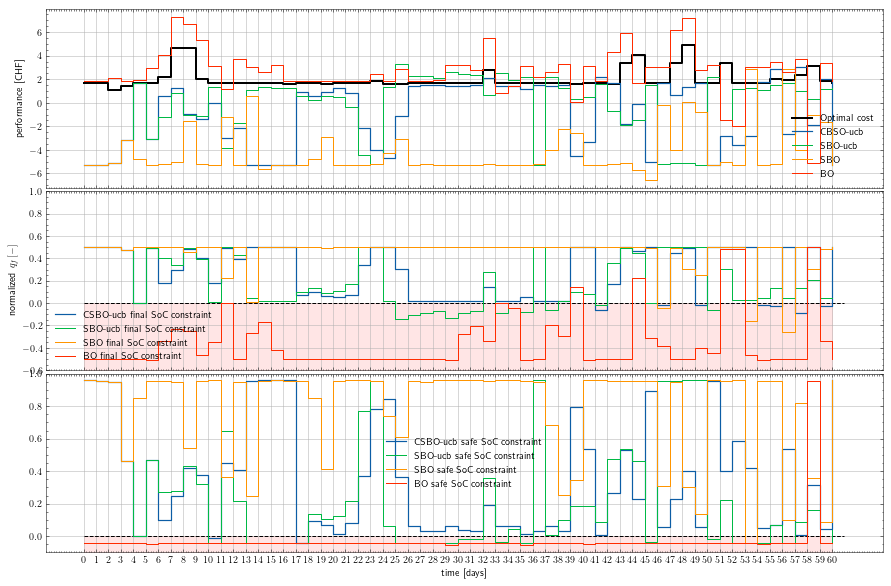

In [37]:
# mpl.rcParams['text.usetex']=True

with plt.style.context('science'):
    err=25e-2
    # plt.step(range(iterations),best_constrained_value(y_meas),where='post',label='SafeOpt')
    fig,ax=plt.subplots(3,sharex=True,figsize=(15,10))
    ax[0].step(range(iterations),-rnd_opt_cst[:iterations],where='post',label='Optimal cost',color='black',linewidth=2)
    ax[0].step(range(iterations),y_post[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
    ax[0].step(range(iterations),y_post_[:,0],where='post',label='SBO-ucb')
    ax[0].step(range(iterations),y_post__[:,0],where='post',label='SBO')
    ax[0].step(range(iterations),y_postva[:,0],where='post',label='BO')
    # ax[0].step(range(iterations),y_prior_[:,0],where='post',label='prior SO-ucb')
    # ax[0].step(range(iterations),y_prior_[:,0],where='post',label='prior SO-ucb')
    # ax[0].step(range(iterations),y_prior[:,0],where='post',label='prior CSO-ucb')
    ax[0].set_xticks(np.arange(0,iterations,1))
    ax[0].set_ylabel('performance [CHF]')
    ax[0].legend()

    ax[1].step(range(iterations),y_post[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
    ax[1].step(range(iterations),y_post_[:,1],where='post',label='SBO-ucb final SoC constraint')
    ax[1].step(range(iterations),y_post__[:,1],where='post',label='SBO final SoC constraint')
    ax[1].step(range(iterations),y_postva[:,1],where='post',label='BO final SoC constraint')
    ax[1].hlines(-S_os_max,0,iterations,'k',linestyles='--')
    ax[1].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)

#     ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
#     ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SBO-ucb final SoC constraint')
#     ax[1].step(range(iterations),y_prior__[:,1],where='post',label='SBO final SoC constraint')
#     ax[1].step(range(iterations),y_priorva[:,1],where='post',label='BO final SoC constraint')

    ax[1].set_ylim([-0.6,1])
    ax[1].set_ylabel(r'normalized $q_f [-]$')
    ax[1].legend()

    ax[2].step(range(iterations),y_post[:,2],where='post',label='CSBO-ucb safe SoC constraint',linewidth=1.2)
    ax[2].step(range(iterations),y_post_[:,2],where='post',label='SBO-ucb safe SoC constraint')
    ax[2].step(range(iterations),y_post__[:,2],where='post',label='SBO safe SoC constraint')
    ax[2].step(range(iterations),y_postva[:,2],where='post',label='BO safe SoC constraint')
    ax[2].hlines(-S_os_max,0,iterations,'k',linestyles='--')
    ax[2].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)
    ax[2].set_ylim([-0.1,1])
    ax[2].set_ylabel(r'normalized $q_s [-]$')    
    ax[2].legend()
    plt.xlabel('time [d]')
#     plt.xlim([0,30])
    plt.subplots_adjust(hspace=0.02)
#     plt.savefig('0.5RBC312_rp_b0_qf_55_beta_2_hp2.png')
plt.show()

save_data(e_ch,'ech_winter',folder='msim_data_312_winter_rp0_qf_55')

In [38]:
name='mtrn1_b2_'
optype='CSBO'
sim_dir='sim_data_312_winter_rp0_qf_55_qs_32_mtrn/'
save_data(x_post,'x_post_'+name+optype,folder=sim_dir)
save_data(y_post,'y_post_'+name+optype,folder=sim_dir)
save_data(x_prior,'x_prior_'+name+optype,folder=sim_dir)
save_data(y_prior,'y_prior_'+name+optype,folder=sim_dir)
optype='SBO'
save_data(x_post_,'x_post_'+name+optype,folder=sim_dir)
save_data(y_post_,'y_post_'+name+optype,folder=sim_dir)
save_data(x_prior_,'x_prior_'+name+optype,folder=sim_dir)
save_data(y_prior_,'y_prior_'+name+optype,folder=sim_dir)
optype='SBOb'
save_data(x_post__,'x_post_'+name+optype,folder=sim_dir)
save_data(y_post__,'y_post_'+name+optype,folder=sim_dir)
save_data(x_prior__,'x_prior_'+name+optype,folder=sim_dir)
save_data(y_prior__,'y_prior_'+name+optype,folder=sim_dir)
optype='BO'
save_data(x_postva,'x_post_'+name+optype,folder=sim_dir)
save_data(y_postva,'y_post_'+name+optype,folder=sim_dir)
save_data(x_priorva,'x_prior_'+name+optype,folder=sim_dir)
save_data(y_priorva,'y_prior_'+name+optype,folder=sim_dir)

save_data(hp,'hyperpar_'+name,folder=sim_dir)
save_data(opt_ucb.gps,'CSBO_'+name,folder=sim_dir,pick=True,npy=False)

sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_post_mtrn1_b2_CSBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/y_post_mtrn1_b2_CSBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_prior_mtrn1_b2_CSBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/y_prior_mtrn1_b2_CSBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_post_mtrn1_b2_SBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/y_post_mtrn1_b2_SBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_prior_mtrn1_b2_SBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/y_prior_mtrn1_b2_SBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_post_mtrn1_b2_SBOb_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/y_post_mtrn1_b2_SBOb_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_prior_mtrn1_b2_SBOb_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/y_prior_mtrn1_b2_SBOb_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_post_mtrn1_b2_BO_20

 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0

# Test RBC parameter

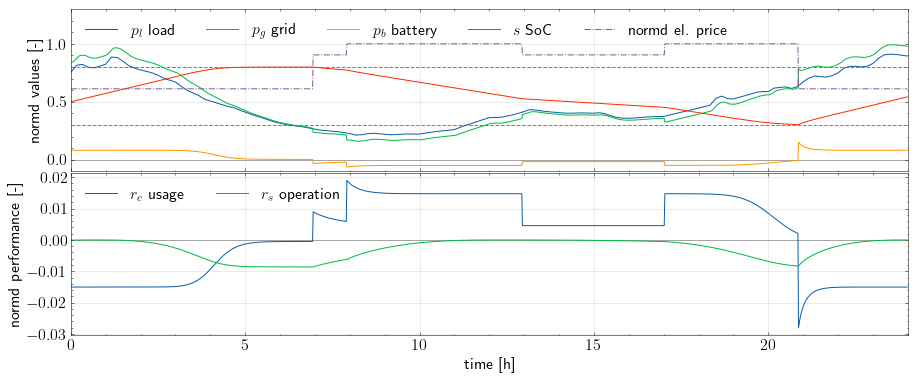

((-6.155345085244887, 1.946738457885866), 54.31231735381455, 30.32786218509283)

In [46]:
RBCpar=opt_ucb.get_maximum(context=0.,beta_estimate=2)
plant_cost(RBCpar[0],plot=True)

# Batch optimization
Test several hyperparameters in a row

In [7]:
# Import model data
data=get_data('model_data/model_winter_data_2022_03_15_0131.csv',npy=False)
data=data.set_index(pd.to_datetime(data.index))

### RBF

In [10]:
# Select hyperparamters
hp1=get_data('hps/ESRBC/hyperpar_loglike1_b2.npy')
hp2=get_data('hps/ESRBC/hyperpar_loglike2_b2.npy')
hp3=get_data('hps/ESRBC/hyperpar_loglike3_b2.npy')
hp4=get_data('hps/ESRBC/hyperpar_loglike4_b2.npy')
#List HPs to evaluate
hps=[hp1,hp2,hp3,hp4]
#Iterate over list of HP, idx: name of HP
for idx,hp in zip([1,2,3,4],hps):
    for beta in [0.5,1,2]:
        #Define context variable
        e_ch=data.e_char.asfreq('D').shift(-2).dropna()# Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
        ctxt=e_ch
        #Set RBF hyperparamters: hp=[R variance,R lengthscales,
        #                            Q1 variance,Q1 lengthscales
        #                            Q2 variance,Q2 lengthscales,
        #                            beta, context lengthscales]

        Vz=hp[0]
        Lz=hp[1]
        Vq=hp[2]
        Lq=hp[3]
        Vqs=hp[4]
        Lqs=hp[5]
        beta=beta
        Lctxt_z=hp[7]
        Lctxt_q=hp[8]
        Lctxt_qs=hp[9]
        #Measurement noise
        noise_cst = 2e-1
        noise_const =5e-4
        noise_safeconst =5e-4
        #Define final SoC constraint
        S_f_sp=55
        #Slack variable, e.g. maximal constraint violation
        S_os_max=0
        #Soft constraints on SoC
        soc_softc=[32,80]
        #Performance metric weigths
        w=[1,0.25]
        #Cost generator
        def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=50,phib=phib):
        #Takes RBC parameters and returns metrics
            p_load=data[:T*day+N_lim[1]]
            x=x0
            i=0
            while True:
        #         i=0 #always first day
                soc_i=50 #always same initial SoC
                res=plant_cost(x=x,T=T,p_load=p_load.copy(),N_lim=N_lim,soc_lim=soc_lim,soc_softc=soc_softc,soc_i=soc_i,phib=phib,plot=False,noise=False)
                c=res[0]
                q=res[1:]  
                #Return performance and constraints metrics and get parameters and iteration number
                x,i=yield w[0]*c[1]+w[1]*c[0],(q[0]-S_f_sp)/soc_std,(q[1]-soc_softc[0])/soc_std
                p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
        #         print('day: ',i)
        #         plt.plot(p_load[N_lim[1]:])
        #         plt.show()

        # Set bounds on parameter domain
        bounds = [(0., 4.),(-1,1)]
        parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
        # Set additional heuristic bounds on parameter domain
        # parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]

        # Define R metric and context kernels
        cost_kernel_ = GPy.kern.RBF(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
        cost_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
        cost_kernel=cost_kernel_*cost_context_kernel
        # Define Q1 metric and context kernels
        const_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
        const_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
        const_kernel=const_kernel_*const_context_kernel
        # Define Q2 metric and context kernels
        safeconst_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
        safeconst_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
        safeconst_kernel=safeconst_kernel_*safeconst_context_kernel
        #Set initial parameters and metrics
        context=np.array([[ctxt[0]]])
        x0=np.array([[0.,-0.5]])
        x=np.hstack([x0,context])
        cost=cost_g(x0.flatten())
        y0= np.atleast_2d(cost.send(None))
        #Build contextual GP models
        cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
        const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
        safeconst_gp= GPy.models.GPRegression(x,y0[:,2,None], safeconst_kernel, noise_var=noise_safeconst)
        #Build GP models
        cost_gp_ = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel_, noise_var=noise_cst)
        const_gp_= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel_, noise_var=noise_const)
        safeconst_gp_= GPy.models.GPRegression(x0,y0[:,2,None], safeconst_kernel_, noise_var=noise_safeconst)
        gp=[cost_gp,const_gp,safeconst_gp]
        gp_=[cost_gp_,const_gp_,safeconst_gp_]
        gp__=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]
        gpva=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]
        #Create BO,SafeOptBO (Berkenkamp), SBO, CSBO
        optva = safeopt.SafeOpt(gpva,parameter_set=parameter_set,fmin=[-np.inf,-np.inf,-np.inf], threshold=np.array([-np.inf,-np.inf,-50]),beta=beta) #BO
        opt = safeopt.SafeOpt(gp__,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta) #SafeOptBO
        opt_ucb_=safeopt.SafeOpt(gp_,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta) #SBO
        opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta,num_contexts=1) #CSBO

        iterations=len(data)*dt//day-2
        #Init eval lists
        y_post=np.empty((iterations,y0.shape[1]))
        x_post=np.empty((iterations,x0.shape[1]))
        x_prior=np.empty((iterations,x0.shape[1]))
        y_prior=[]
        y_prior.append(y0.flatten())

        y_post_=np.empty((iterations,y0.shape[1]))
        x_post_=np.empty((iterations,x0.shape[1]))
        x_prior_=np.empty((iterations,x0.shape[1]))
        y_prior_=[]
        y_prior_.append(y0.flatten())

        y_post__=np.empty((iterations,y0.shape[1]))
        x_post__=np.empty((iterations,x0.shape[1]))
        x_prior__=np.empty((iterations,x0.shape[1]))
        y_prior__=[]
        y_prior__.append(y0.flatten())

        y_postva=np.empty((iterations,y0.shape[1]))
        x_postva=np.empty((iterations,x0.shape[1]))
        x_priorva=np.empty((iterations,x0.shape[1]))
        y_priorva=[]
        y_priorva.append(y0.flatten())

        #Start simulation: iteration over different days
        for i in range(iterations):
            print('day: ',i)
            # Get next posterior parameters (for the same day after updating model)
            try:
                x_post_[i,:] = opt_ucb_.optimize(ucb=True)        
                x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
                x_post__[i,:] = opt.optimize()
                x_postva[i,:] = optva.optimize(ucb=True)

            except EnvironmentError as e:
                print(e)
                x_post_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]
                x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]
                x_post__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]
                x_postva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]
            # Get evaluation on the current day with the posterior parameters
            y_post[i,:] = cost.send((x_post[i,:].flatten(),i))
            y_post_[i,:] = cost.send((x_post_[i,:].flatten(),i))
            y_post__[i,:] = cost.send((x_post__[i,:].flatten(),i))
            y_postva[i,:] = cost.send((x_postva[i,:].flatten(),i))    

            # Get context of next day
            context=np.array([ctxt[i+1]])
            print('context= ',context)
            # Get prior parameters for next day (parameters based on next day context forecast)
            try:
                x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
                x_prior_[i,:] =  opt_ucb_.optimize(ucb=True)
                x_prior__[i,:] =  opt.optimize(ucb=False)
                x_priorva[i,:] =  optva.optimize(ucb=True)

            except EnvironmentError as e:
                print(e)
                x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    
                x_prior_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]   
                x_prior__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]    
                x_priorva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]            
            # Get evaluation with prior parameters on the next day
            y_prior.append(cost.send((x_prior[i,:].flatten(),i+1)))
            y_prior_.append(cost.send((x_prior_[i,:].flatten(),i+1)))
            y_prior__.append(cost.send((x_prior__[i,:].flatten(),i+1)))    
            y_priorva.append(cost.send((x_priorva[i,:].flatten(),i+1)))    
            print('opt parameter and cost: ',x_post[i,:],y_post[i,:])
            # Update GP models with new evaluations
            opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)
            opt_ucb_.add_new_data_point(x_prior_[i,:], np.atleast_2d(y_prior_[-1])) 
            opt.add_new_data_point(x_prior__[i,:], np.atleast_2d(y_prior__[-1]))   
            optva.add_new_data_point(x_priorva[i,:], np.atleast_2d(y_priorva[-1])) 
            print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))

        y_prior=np.array(y_prior[:-1])
        y_prior_=np.array(y_prior_[:-1])
        y_prior__=np.array(y_prior__[:-1])
        y_priorva=np.array(y_priorva[:-1])

        #Uncomment to display MAE if rnd_opt_cst defined
        # err=-rnd_opt_cst.flatten()[10:iterations]-y_prior[10:,0]
        # print(np.abs(err).sum()/(iterations-10))

        with plt.style.context('science'):
            err=25e-2
            fig,ax=plt.subplots(2,sharex=True,figsize=(15,10))
            ax[0].step(range(iterations),-rnd_opt_cst[:iterations],where='post',label='Optimal cost',color='black',linewidth=2)
    #         ax[0].step(range(iterations),y_post[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
    #         ax[0].step(range(iterations),y_post_[:,0],where='post',label='SBO-ucb')
    #         ax[0].step(range(iterations),y_post__[:,0],where='post',label='SBO')
    #         ax[0].step(range(iterations),y_postva[:,0],where='post',label='BO')

            ax[0].step(range(iterations),y_prior[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
            ax[0].step(range(iterations),y_prior_[:,0],where='post',label='SBO-ucb')
            ax[0].step(range(iterations),y_prior__[:,0],where='post',label='SBO')
            ax[0].step(range(iterations),y_priorva[:,0],where='post',label='BO')
            ax[0].set_xticks(np.arange(0,iterations,1))
            ax[0].set_ylabel('performance [CHF]')
            ax[0].legend()
            
    #         ax[1].step(range(iterations),y_post[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
    #         ax[1].step(range(iterations),y_post_[:,1],where='post',label='SBO-ucb final SoC constraint')
    #         ax[1].step(range(iterations),y_post__[:,1],where='post',label='SBO final SoC constraint')
    #         ax[1].step(range(iterations),y_postva[:,1],where='post',label='BO final SoC constraint')
            ax[1].hlines(-S_os_max,0,iterations,'k',linestyles='--')
            ax[1].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)
            ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
            ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SBO-ucb final SoC constraint')
            ax[1].step(range(iterations),y_prior__[:,1],where='post',label='SBO final SoC constraint')
            ax[1].step(range(iterations),y_priorva[:,1],where='post',label='BO final SoC constraint')
            ax[1].set_ylim([-0.6,1])
            ax[1].set_ylabel(r'normalized $q_f [-]$')
            ax[1].legend()
            
            ax[2].step(range(iterations),y_post[:,2],where='post',label='CSBO-ucb safe SoC constraint',linewidth=1.2)
            ax[2].step(range(iterations),y_post_[:,2],where='post',label='SBO-ucb safe SoC constraint')
            ax[2].step(range(iterations),y_post__[:,2],where='post',label='SBO safe SoC constraint')
            ax[2].step(range(iterations),y_postva[:,2],where='post',label='BO safe SoC constraint')
            ax[2].hlines(-S_os_max,0,iterations,'k',linestyles='--')
            ax[2].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)
            ax[2].set_ylim([-0.1,1])
            ax[2].set_ylabel(r'normalized $q_s [-]$')    
            ax[2].legend()
            plt.xlabel('time [d]')
            plt.xlim([0,30])
            plt.subplots_adjust(hspace=0.02)
    #         plt.savefig(f'RBC312_rp_b0_qf_55_beta_{beta}_{par_names[idx]}_model.png')
        plt.show()
    #     name=f'{par_names[idx]}_b{beta}_'
        name=f'loglike{idx}_b{beta}_'
        optype='CSBO'
        sim_dir='sim_data_ESRBC_winter_rp0_gb_qf_55_qs_32'
        save_data(x_post,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior,'y_prior_'+name+optype,folder=sim_dir)
        optype='SBO'
        save_data(x_post_,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post_,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior_,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior_,'y_prior_'+name+optype,folder=sim_dir)
        optype='SBOb'
        save_data(x_post__,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post__,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior__,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior__,'y_prior_'+name+optype,folder=sim_dir)
        optype='BO'
        save_data(x_postva,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_postva,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_priorva,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_priorva,'y_prior_'+name+optype,folder=sim_dir)

        save_data(hp,'hyperpar_'+name,folder=sim_dir)
        save_data(opt_ucb.gps,'CSBO_'+name,folder=sim_dir,pick=True,npy=False)
        save_data(opt_ucb_.gps,'SBO_'+name,folder=sim_dir,pick=True,npy=False)    

This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
day:  0
context=  [0.]
opt parameter and cost:  [ 0.06030151 -0.26633166] [-8.524306    0.4981907   0.95764872]
current max estiamte ucb=  (array([0.08040201, 0.04522613]), -0.8278572729131171, -0.4158010890289192)
day:  1
context=  [0.03046038]


KeyboardInterrupt: 

### Mattern32

In [79]:
# Winter hyperparamters
hp1=[5.8**2,[1.9,1.12], #cost
    0.27**2,[0.95,0.478],# const
    0.25**2,[0.59, 0.38],#safe 
    2,#beta
    2.45,1.35,0.841] #contexts lenght
hp2=[4**2,[1.28,0.937], #cost
    0.303**2,[1.62,0.757],# const
    0.309**2,[0.695, 0.697],#safe 
    2,#beta
    1.08,1.49,0.543] #contexts lenght

hp3=[4.9**2,[1.3,0.698], #cost
    0.3**2,[0.682,0.478],# const
    0.263**2,[0.425, 0.472],#safe 
    2,#beta
    1.06,0.3,0.77] #contexts lenght

hps=[hp1,hp2,hp3]

In [12]:

from itertools import product
betas=[0.5,1,2]
for beta in betas:
    for idx,hp in enumerate(hps):
        print(beta,hp)
        e_ch=data.e_char.asfreq('D').shift(-2).dropna()
        ctxt=e_ch
        Vz=hp[0]
        Lz=hp[1]
        Vq=hp[2]
        Lq=hp[3]
        Vqs=hp[4]
        Lqs=hp[5]
        beta=beta
        Lctxt_z=hp[7]
        Lctxt_q=hp[8]
        Lctxt_qs=hp[9]

        noise_cst = 1e-2#cst_mmnt_noise.mean()/10
        noise_const =2e-5
        noise_safeconst =1e-6
        S_f_sp=55
        S_os_max=0
        soc_lim=[30,80]
        soc_softc=[32,80]
        # opt_cost=rnd_opt_cst[0]
        def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=50,phib=phib):
            p_load=data[:T*day+N_lim[1]]
            x=x0
            i=0
            while True:
        #         i=0 #always first day
                soc_i=50 #always same soc_i
                res=plant_cost(x=x,T=T,p_load=p_load.copy(),N_lim=N_lim,soc_lim=soc_lim,soc_softc=soc_softc,soc_i=soc_i,phib=phib,plot=False,noise=False)
                c=res[0]
                q=res[1:]  
                x,i=yield c[1]+50*c[0],(q[0]-S_f_sp)/soc_std,(q[1]-soc_softc[0])/soc_std
                p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
        #         print('day: ',i)
        #         plt.plot(p_load[N_lim[1]:])
        #         plt.show()
        bounds = [(0., 4.),(-1,1)]
        parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
        # parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]
        # Define Kernel
        cost_kernel_ = GPy.kern.Matern32(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
        cost_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
        cost_kernel=cost_kernel_*cost_context_kernel

        const_kernel_=GPy.kern.Matern32(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
        const_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
        const_kernel=const_kernel_*const_context_kernel

        safeconst_kernel_=GPy.kern.Matern32(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
        safeconst_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
        safeconst_kernel=safeconst_kernel_*safeconst_context_kernel

        context=np.array([[ctxt[0]]])
        x0=np.array([[0.,-0.5]])
        x=np.hstack([x0,context])
        cost=cost_g(x0.flatten())
        y0= np.atleast_2d(cost.send(None))
        cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
        const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
        safeconst_gp= GPy.models.GPRegression(x,y0[:,2,None], safeconst_kernel, noise_var=noise_safeconst)

        cost_gp_ = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel_, noise_var=noise_cst)
        const_gp_= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel_, noise_var=noise_const)
        safeconst_gp_= GPy.models.GPRegression(x0,y0[:,2,None], safeconst_kernel_, noise_var=noise_safeconst)

        gp=[cost_gp,const_gp,safeconst_gp]
        gp_=[cost_gp_,const_gp_,safeconst_gp_]
        gp__=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]
        gpva=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]

        # The optimization routine
        optva = safeopt.SafeOpt(gpva,parameter_set=parameter_set,fmin=[-np.inf,-np.inf,-np.inf], threshold=np.array([-np.inf,-np.inf,-50]),beta=beta)
        opt = safeopt.SafeOpt(gp__,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta)
        opt_ucb_=safeopt.SafeOpt(gp_,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta)
        opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta,num_contexts=1)
        # opt_ucb=safeopt.SafeOptSwarm(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-5]))
        iterations=len(data)*dt//day-2

        y_post=np.empty((iterations,y0.shape[1]))
        x_post=np.empty((iterations,x0.shape[1]))
        x_prior=np.empty((iterations,x0.shape[1]))
        y_prior=[]
        y_prior.append(y0.flatten())

        y_post_=np.empty((iterations,y0.shape[1]))
        x_post_=np.empty((iterations,x0.shape[1]))
        x_prior_=np.empty((iterations,x0.shape[1]))
        y_prior_=[]
        y_prior_.append(y0.flatten())

        y_post__=np.empty((iterations,y0.shape[1]))
        x_post__=np.empty((iterations,x0.shape[1]))
        x_prior__=np.empty((iterations,x0.shape[1]))
        y_prior__=[]
        y_prior__.append(y0.flatten())

        y_postva=np.empty((iterations,y0.shape[1]))
        x_postva=np.empty((iterations,x0.shape[1]))
        x_priorva=np.empty((iterations,x0.shape[1]))
        y_priorva=[]
        y_priorva.append(y0.flatten())

        for i in range(iterations):
            print(i)
            # Get optimizer for same day
            try:
                x_post_[i,:] = opt_ucb_.optimize(ucb=True)        
                x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
                x_post__[i,:] = opt.optimize()
                x_postva[i,:] = optva.optimize(ucb=True)

            except EnvironmentError as e:
                print(e)
                x_post_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]
                x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]
                x_post__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]
                x_postva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]

            y_post[i,:] = cost.send((x_post[i,:].flatten(),i))
            y_post_[i,:] = cost.send((x_post_[i,:].flatten(),i))
            y_post__[i,:] = cost.send((x_post__[i,:].flatten(),i))
            y_postva[i,:] = cost.send((x_postva[i,:].flatten(),i))    
            # Get context of next day
            context=np.array([ctxt[i+1]])
            print('context= ',context)
            try:
                x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
                x_prior_[i,:] =  opt_ucb_.optimize(ucb=True)
                x_prior__[i,:] =  opt.optimize(ucb=False)
                x_priorva[i,:] =  optva.optimize(ucb=True)

            except EnvironmentError as e:
                print(e)
                x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    
                x_prior_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]   
                x_prior__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]    
                x_priorva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]            

            y_prior.append(cost.send((x_prior[i,:].flatten(),i+1)))
            y_prior_.append(cost.send((x_prior_[i,:].flatten(),i+1)))
            y_prior__.append(cost.send((x_prior__[i,:].flatten(),i+1)))    
            y_priorva.append(cost.send((x_priorva[i,:].flatten(),i+1)))    


            print('opt parameter and cost: ',x_post[i,:],y_post[i,:])
            opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)
            opt_ucb_.add_new_data_point(x_prior_[i,:], np.atleast_2d(y_prior_[-1])) 
            opt.add_new_data_point(x_prior__[i,:], np.atleast_2d(y_prior__[-1]))   
            optva.add_new_data_point(x_priorva[i,:], np.atleast_2d(y_priorva[-1])) 

            print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))
        y_prior=np.array(y_prior[:-1])
        y_prior_=np.array(y_prior_[:-1])
        y_prior__=np.array(y_prior__[:-1])
        y_priorva=np.array(y_priorva[:-1])

        err=-rnd_opt_cst.flatten()[10:iterations]-y_prior[10:,0]
        print(np.abs(err).sum()/(iterations-10))


        with plt.style.context('science'):
            err=25e-2
            fig,ax=plt.subplots(2,sharex=True,figsize=(15,10))
            ax[0].step(range(iterations),-rnd_opt_cst[:iterations],where='post',label='Optimal cost',color='black',linewidth=2)
    #         ax[0].step(range(iterations),y_post[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
    #         ax[0].step(range(iterations),y_post_[:,0],where='post',label='SBO-ucb')
    #         ax[0].step(range(iterations),y_post__[:,0],where='post',label='SBO')
    #         ax[0].step(range(iterations),y_postva[:,0],where='post',label='BO')

            ax[0].step(range(iterations),y_prior[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
            ax[0].step(range(iterations),y_prior_[:,0],where='post',label='SBO-ucb')
            ax[0].step(range(iterations),y_prior__[:,0],where='post',label='SBO')
            ax[0].step(range(iterations),y_priorva[:,0],where='post',label='BO')
            ax[0].set_xticks(np.arange(0,iterations,1))
            ax[0].set_ylabel('performance [CHF]')
            ax[0].legend()
            
    #         ax[1].step(range(iterations),y_post[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
    #         ax[1].step(range(iterations),y_post_[:,1],where='post',label='SBO-ucb final SoC constraint')
    #         ax[1].step(range(iterations),y_post__[:,1],where='post',label='SBO final SoC constraint')
    #         ax[1].step(range(iterations),y_postva[:,1],where='post',label='BO final SoC constraint')
            ax[1].hlines(-S_os_max,0,iterations,'k',linestyles='--')
            ax[1].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)
            ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
            ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SBO-ucb final SoC constraint')
            ax[1].step(range(iterations),y_prior__[:,1],where='post',label='SBO final SoC constraint')
            ax[1].step(range(iterations),y_priorva[:,1],where='post',label='BO final SoC constraint')
            ax[1].set_ylim([-0.6,1])
            ax[1].set_ylabel(r'normalized $q_f [-]$')
            ax[1].legend()
            
            ax[2].step(range(iterations),y_post[:,2],where='post',label='CSBO-ucb safe SoC constraint',linewidth=1.2)
            ax[2].step(range(iterations),y_post_[:,2],where='post',label='SBO-ucb safe SoC constraint')
            ax[2].step(range(iterations),y_post__[:,2],where='post',label='SBO safe SoC constraint')
            ax[2].step(range(iterations),y_postva[:,2],where='post',label='BO safe SoC constraint')
            ax[2].hlines(-S_os_max,0,iterations,'k',linestyles='--')
            ax[2].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)
            ax[2].set_ylim([-0.1,1])
            ax[2].set_ylabel(r'normalized $q_s [-]$')    
            ax[2].legend()
            plt.xlabel('time [d]')
            plt.xlim([0,30])
            plt.subplots_adjust(hspace=0.02)
    #         plt.savefig(f'RBC312_rp_b0_qf_55_beta_{beta}_{par_names[idx]}_model.png')
        plt.show()
        name=f'loglike{idx}_b{beta}_'
        optype='CSBO'
        sim_dir='sim_data_312_winter_rp0_qf_55_qs_32_mtrn/'
        save_data(x_post,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior,'y_prior_'+name+optype,folder=sim_dir)
        optype='SBO'
        save_data(x_post_,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post_,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior_,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior_,'y_prior_'+name+optype,folder=sim_dir)
        optype='SBOb'
        save_data(x_post__,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post__,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior__,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior__,'y_prior_'+name+optype,folder=sim_dir)
        optype='BO'
        save_data(x_postva,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_postva,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_priorva,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_priorva,'y_prior_'+name+optype,folder=sim_dir)

        save_data(hp,'hyperpar_'+name,folder=sim_dir)
        save_data(opt_ucb.gps,'CSBO_'+name,folder=sim_dir,pick=True,npy=False)
        save_data(opt_ucb_.gps,'SBO_'+name,folder=sim_dir,pick=True,npy=False)    

0.5 [4.2848999999999995 list([0.292, 0.144]) 0.04000000000000001
 list([0.266, 0.149]) 0.0625 list([0.163, 0.118]) 0.5 0.7 2.13 0.566]
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]


KeyboardInterrupt: 

# Evaluation 

In [291]:
import glob
paths=glob.glob('sim_data_312_winter_rp_qf/y_post_loglike_b*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
for i, beta in enumerate(betas):
    if beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas


['2022_03_05_0602',
 '2022_03_05_0602',
 '2022_03_05_0242',
 '2022_03_05_0546',
 '2022_03_05_0602',
 '2022_03_05_0637',
 '2022_03_05_0637',
 '2022_03_05_0546',
 '2022_03_05_0546',
 '2022_03_05_0242',
 '2022_03_05_0637',
 '2022_03_05_0637',
 '2022_03_05_0602',
 '2022_03_05_0546']

In [296]:
ct=10
mae=[]
cnst10=[]
cnst0=[]
for i,path in enumerate(paths):
    cst=get_data(path)[:,0]
    err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:]
    mae.append(np.abs(err).sum()/(len(cst)-ct))
    cnst=get_data(path)[:,1]
    cnst10.append((cnst<-0.1).astype(int).sum())
    cnst0.append((cnst<-0).astype(int).sum())    
    print(file_paths[i],(cnst<-0).astype(int).sum())

y_post_loglike_b2_SBO_2022_03_05_0602.npy 5
y_post_loglike_b2_BO_2022_03_05_0602.npy 36
y_post_loglike_b2_CSBO_2022_03_05_0242.npy 19
y_post_loglike_b1_CSBO_2022_03_05_0546.npy 5
y_post_loglike_b2_SBOb_2022_03_05_0602.npy 1
y_post_loglike_b05_SBOb_2022_03_05_0637.npy 2
y_post_loglike_b05_BO_2022_03_05_0637.npy 37
y_post_loglike_b1_BO_2022_03_05_0546.npy 36
y_post_loglike_b1_SBO_2022_03_05_0546.npy 6
y_post_loglike_b2_SBO_2022_03_05_0242.npy 5
y_post_loglike_b05_SBO_2022_03_05_0637.npy 13
y_post_loglike_b05_CSBO_2022_03_05_0637.npy 19
y_post_loglike_b2_CSBO_2022_03_05_0602.npy 0
y_post_loglike_b1_SBOb_2022_03_05_0546.npy 1


In [292]:
eval_df=pd.DataFrame({'optype':optypes,'beta':betas,'mae':mae,'cnst0':cnst0,'cnst10':cnst10,'date':dates})
eval_df=eval_df.set_index(['beta','optype']).sort_index()
eval_df.sort_values('mae')


mae  cnst0  cnst10             date
beta optype                                          
0.5  BO      0.986575     37      37  2022_03_05_0637
     CSBO    0.635154     19       2  2022_03_05_0637
     SBO     0.286739     13       0  2022_03_05_0637
     SBOb    2.986477      2       2  2022_03_05_0637
1.0  BO      1.370720     36      34  2022_03_05_0546
     CSBO    1.215400      5       0  2022_03_05_0546
     SBO     0.368464      6       0  2022_03_05_0546
     SBOb    3.231044      1       1  2022_03_05_0546
2.0  BO      1.147769     36      35  2022_03_05_0602
     CSBO    0.931918     19       4  2022_03_05_0242
     CSBO    1.795221      0       0  2022_03_05_0602
     SBO     0.618568      5       1  2022_03_05_0602
     SBO     0.618568      5       1  2022_03_05_0242
     SBOb    4.086556      1       1  2022_03_05_0602

3 3 1


 /Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim/../safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
 /Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim/../safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


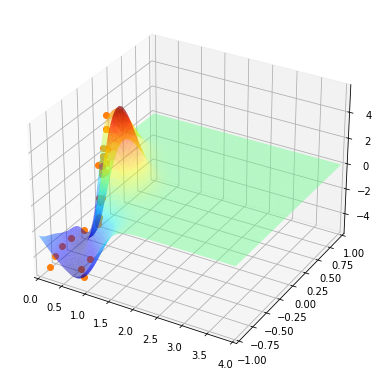

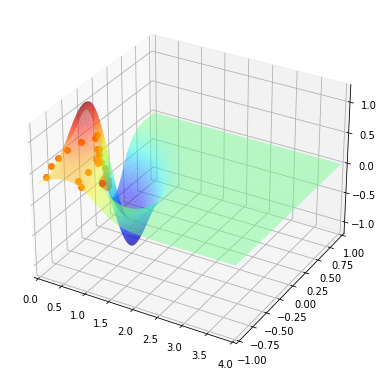

In [140]:
opt_ucb.context=[[0.3]]
opt_ucb.plot(100,plot_3d=True)

3 3 1


 /Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim/../safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
 /Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim/../safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


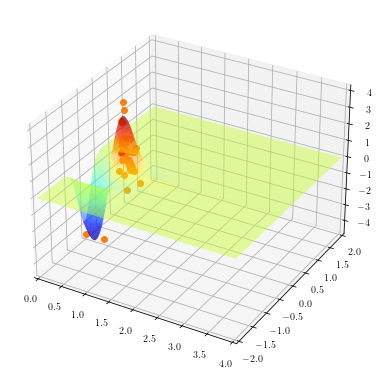

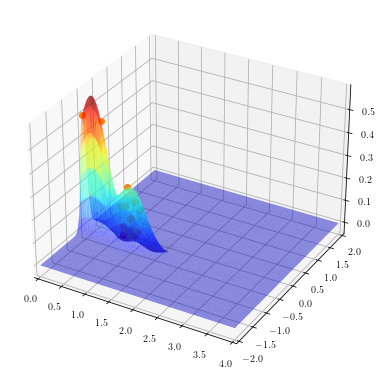

In [66]:
opt_ucb.context=[[0.1]]
opt_ucb.plot(100,plot_3d=True)

In [69]:
def gmax_const(opt,cnt=S_os_max):     
    x,y = opt.data
    max_idx=y[y[:,1]>=-cnt][:,0].argmax()
    return x[y[:,1]>=-cnt][max_idx], y[y[:,1]>=-cnt][:,0].max()
gmax_const(opt_ucb,0)

(array([ 0.83366733, -0.42084168,  0.08682725]), 4.150355788998919)